In [6]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import gc
import os
import re
import time


import s2sphere
from tqdm import tqdm_notebook
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/work/github/gojek_takehome/infra/creds/serviceaccount.json"

import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
client = bigquery.Client()
storage_client = storage.Client()

%load_ext rpy2.ipython
%load_ext google.cloud.bigquery

# Problem Statement

For this take home, we will be building a microservice with 3 endpoints. The results they return will be based on the following tables found in GCP's BIGQUERY public data sets.


| Tables |
| --- |
| tlc_green_trips_2014 |
| tlc_green_trips_2015 |
| tlc_green_trips_2016 |
| tlc_green_trips_2017 |
| tlc_yellow_trips_2015 |
| tlc_yellow_trips_2016 |
| tlc_yellow_trips_2017 |

In [4]:
# Green taxis
greens = "tlc_green_trips_{YEAR}"
tables = [greens.format(YEAR=year) for year in [2014, 2015, 2016, 2017]]
# Yellow taxis
yellows = "tlc_yellow_trips_{YEAR}"
tables.extend([yellows.format(YEAR=year) for year in [2015, 2016, 2017]])
tables

['tlc_green_trips_2014',
 'tlc_green_trips_2015',
 'tlc_green_trips_2016',
 'tlc_green_trips_2017',
 'tlc_yellow_trips_2015',
 'tlc_yellow_trips_2016',
 'tlc_yellow_trips_2017']

Lets check out how the table looks like:

In [10]:
%%bigquery 

SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014` LIMIT 5

,vendor_id,pickup_datetime,dropoff_datetime,store_and_fwd_flag,rate_code,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,...,mta_tax,tip_amount,tolls_amount,ehail_fee,total_amount,payment_type,distance_between_service,time_between_service,trip_type,imp_surcharge
0,1,2014-06-07 12:26:15,2014-06-07 13:09:31,N,1,-73.870522,40.733963,-73.737892,40.754864,1,...,0.5,0.0,0.0,None,29.0,2,None,None,1.0,None
1,1,2014-12-18 15:28:43,2014-12-18 16:15:25,N,1,-73.967270,40.695385,-73.782303,40.648777,1,...,0.5,8.5,0.0,None,51.0,1,None,None,1.0,None
2,1,2014-03-23 01:28:58,2014-03-23 01:56:27,N,1,-73.946854,40.692650,-73.989410,40.758247,1,...,0.5,2.5,0.0,None,30.0,1,None,None,NaN,None
3,1,2014-11-14 17:01:33,2014-11-14 17:36:02,N,1,-74.000198,40.685997,-73.956543,40.747772,1,...,0.5,5.6,0.0,None,33.6,1,None,None,1.0,None
4,2,2014-06-29 12:57:00,2014-06-29 13:28:33,N,1,-73.954750,40.718643,-73.986366,40.669212,1,...,0.5,0.0,0.0,None,26.0,2,None,None,1.0,None


## Endpoint 1: Total trips per day


```bash
START_DATE=2019-01-01
END_DATE=2019-01-31

curl http://${URL}:${PORT}/total_trips?start=${START_DATE}&end=${END_DATE}
```

Returning

```json
{
   "data":[
      {
         "date":"2019-01-01",
         "total_trips":321
      },
      {
         "date":"2019-01-02",
         "total_trips":432
      },
      {
         "date":"2019-01-03",
         "total_trips":543
      },
      {
         "date":"2019-01-31",
         "total_trips":987
      }
   ]
}
```

Example query:

In [127]:
%%bigquery

WITH num_pickups as (
    SELECT 
        CAST(pickup_datetime AS date) as date,
        COUNT(*)  as total_trips,
        2014 as year,
        'green' AS taxi_type
    FROM
        `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014`
    GROUP BY CAST(pickup_datetime AS date)
)
SELECT 
    *
FROM num_pickups 
ORDER BY date
LIMIT 5

,date,total_trips,year,taxi_type
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


We pull the following data using the following function:

In [3]:
def get_trips_per_day(tables):
    """
    Gets trip per day
    
    Summarises the # of trips per day in each table and 
    returns them as a concatenated pandas dataframe
    
    Parameters
    ------
    
    tables: list[str]
        list of table names
        
    Example
    ------
    >>> tables = [
        'tlc_green_trips_2014','tlc_green_trips_2015',
        'tlc_green_trips_2016','tlc_green_trips_2017',
        'tlc_yellow_trips_2015','tlc_yellow_trips_2016',
        'tlc_yellow_trips_2017'
        ]
    >>> df = get_trips_per_day(tables)
    """
    query = """
        WITH num_pickups as (
            SELECT 
            CAST(pickup_datetime AS date) as date,
            COUNT(*)  AS total_trips,
            {YEAR} AS year,
            '{COLOR}' AS color
        FROM
            `bigquery-public-data.new_york_taxi_trips.{TABLE}`
        GROUP BY CAST(pickup_datetime AS date)
        )
        SELECT * FROM num_pickups ORDER BY date
            """
    
    dfs = []
    for table in tables:
        (_, color, _, year) = re.split("_", table)
        dfs.append(client.query(
            query.format(
                TABLE=table, 
                YEAR=year,
                COLOR=color
            )
        ).to_dataframe())
    return pd.concat(dfs)

In [4]:
df = get_trips_per_day(tables)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2609 entries, 0 to 384
Data columns (total 4 columns):
date           2609 non-null object
total_trips    2609 non-null int64
year           2609 non-null int64
color          2609 non-null object
dtypes: int64(2), object(2)
memory usage: 101.9+ KB


,date,total_trips,year,color
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


### Sanity Check


The data is dirty, some rows have timestamps outside of the year which the tables represent

2014-01-01 < Date 2018-1-1

In [5]:
firstdate = pd.to_datetime("2014-1-1").date()
lastdate = pd.to_datetime("2018-1-1").date()
outside_range = pd.concat([
    df.query('date < @firstdate'),
    df.query('date >= @lastdate')])
print("""
Earliest Date: {}
Latest Date: {}
Number of rows not in date range: {}
""".format(
    df.date.min().strftime("%Y-%m-%d"), 
    df.date.max().strftime("%Y-%m-%d"),
    outside_range.shape[0]
))


Earliest Date: 2001-01-01
Latest Date: 2053-03-21
Number of rows not in date range: 52



In [24]:
def get_total_trips_per_day(df, start_date="2014-1-1", end_date="2018-1-1"):
    firstdate = pd.to_datetime(start_date).date()
    lastdate = pd.to_datetime(end_date).date()
    cleaned_table = (df.query('@firstdate <= date < @lastdate')
        .loc[:, ['date', 'total_trips', 'color']]
        .groupby(['date', 'color'])
        .sum()
        .reset_index())
    return cleaned_table
counts_df = get_total_trips_per_day(df)

counts_df.head()

,date,color,total_trips
0,2014-01-01,green,25608
1,2014-01-02,green,19061
2,2014-01-03,green,13436
3,2014-01-04,green,23697
4,2014-01-05,green,20560


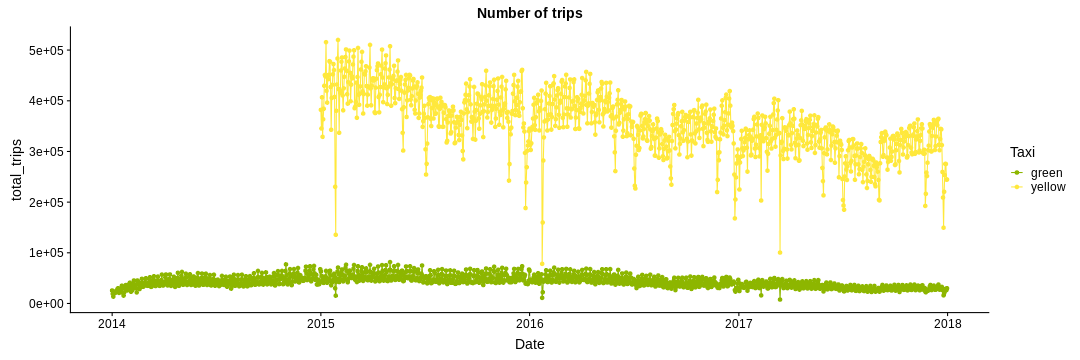

In [23]:
%%R -i counts_df -w 15 -h 5 -u in

suppressPackageStartupMessages({
    library(ggplot2)
    library(lubridate)
    library(cowplot)
})

ggplot(counts_df, aes(ymd(date), total_trips,  color=color)) +
    geom_line(aes(group=color)) +
    geom_point() +
    scale_color_manual("Taxi", values=c("#8db600", "#FFE83C")) +
    labs(title='Number of trips', x="Date")

> There seems to be much lesser data between in 2014 compared to the rest of the dates

For the route, we will be using the following function to return the data.

In [27]:
df.head()

,date,total_trips,year,color
0,2014-01-01,25608,2014,green
1,2014-01-02,19061,2014,green
2,2014-01-03,13436,2014,green
3,2014-01-04,23697,2014,green
4,2014-01-05,20560,2014,green


In [31]:
df = df.loc[:, ["date", "total_trips"]].groupby(["date"]).sum().reset_index()

In [32]:
def get_trips(df, start='2016-01-01', end='2016-01-10', return_json=False):
    firstdate = pd.to_datetime(start).date()
    lastdate = pd.to_datetime(end).date()
    trips = (df
         .query('@firstdate <= date < @lastdate')
         .loc[:,['date', 'total_trips']]
         .assign(date = lambda df: df.date.apply(lambda day: day.strftime("%Y-%m-%d")))
    )
    return trips.to_json(orient='records') if return_json else  trips.to_dict(orient='records')

In [33]:
get_trips(df)

[{'date': '2016-01-01', 'total_trips': 409433},
 {'date': '2016-01-02', 'total_trips': 359789},
 {'date': '2016-01-03', 'total_trips': 347148},
 {'date': '2016-01-04', 'total_trips': 359911},
 {'date': '2016-01-05', 'total_trips': 385593},
 {'date': '2016-01-06', 'total_trips': 390541},
 {'date': '2016-01-07', 'total_trips': 407705},
 {'date': '2016-01-08', 'total_trips': 443057},
 {'date': '2016-01-09', 'total_trips': 462686}]

## Endpoint 2: Fare heatmap


The average fare (fare_amount) per pick up location  [S2 ID](http://s2geometry.io/)  at level 16 for the given date.

```bash
DATE=2019-01-01

curl http://${URL}:${PORT}/average_fare_heatmap?date=${DATE}
```

```json
{
   "data":[
      {
         "s2id":"951977d37",
         "fare":13.21
      },
      {
         "s2id":"951977d39",
         "fare":4.32
      },
      {
         "s2id":"951977d40",
         "fare":5.43
      },
      {
         "s2id":"951978321",
         "fare":9.87
      }
   ]
}
```


### S2 ID

We will be using the `s2sphere` package to convert the latitutde and longitude values to unique S2 Cell Ids

**Example**: 

Let's make use of Singapore's LatLng:



In [5]:
latlong = (1.3521, 103.8198)
pos = s2sphere.LatLng.from_degrees(*latlong)
s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
s2cell = re.sub(r"0+$", "", str(s2cell))
s2cell = re.sub(r"^CellId: ", "", s2cell)
s2cell

'31da10ccf'

In [35]:
s2sphere.sphere.CellId().from_token('31da10ccf')

CellId: 31da10ccf0000000

In [6]:
for i in ['951977d37', '951977d39', '951977d40', '951978321']:
    print(f"Cell_id: {i} Latlong:", end=' '); print(*s2sphere.sphere.CellId().from_token(i).to_lat_lng().__dict__['_LatLng__coords'])

Cell_id: 951977d37 Latlong: -0.5243605967812942 -0.8925542511101803
Cell_id: 951977d39 Latlong: -0.5243685601378298 -0.8925770554588418
Cell_id: 951977d40 Latlong: -0.524391169863365 -0.8926112628472346
Cell_id: 951978321 Latlong: -0.5241589286291036 -0.8934439625424014


In [189]:
%%bigquery example_df

select * from `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014` limit 5

In [192]:
example_df.iloc[1,:]

vendor_id                                     2
pickup_datetime             2014-08-09 11:59:33
dropoff_datetime            2014-08-09 13:07:51
store_and_fwd_flag                            N
rate_code                                     1
pickup_longitude                        -73.979
pickup_latitude                         40.6932
dropoff_longitude                      -73.9976
dropoff_latitude                        40.7661
passenger_count                               5
trip_distance                              7.15
fare_amount                                  43
extra                                         0
mta_tax                                     0.5
tip_amount                                    0
tolls_amount                                  0
ehail_fee                                  None
total_amount                               43.5
payment_type                                  2
distance_between_service                   None
time_between_service                    

In [223]:
(example_df.loc[:, 
    [
        "pickup_datetime", 
        "pickup_latitude", 
        "pickup_longitude", 

        "fare_amount", 
        "mta_tax", 
        "tip_amount",
        "Tolls_amount",
        "ehail_fee", 
        "extra",
        "total_amount"]
    ]
    .assign(myown = lambda df: df.fare_amount + df.mta_tax + df.tip_amount + df.extra)
)

,pickup_datetime,pickup_longitude,pickup_latitude,fare_amount,mta_tax,tip_amount,Tolls_amount,ehail_fee,extra,total_amount,myown
0,2014-03-20 11:12:38,-73.972992,40.693218,28.5,0.5,5.70,NaN,None,0.0,34.70,34.70
1,2014-08-09 11:59:33,-73.979050,40.693157,43.0,0.5,0.00,NaN,None,0.0,43.50,43.50
2,2014-10-03 14:11:50,-73.946159,40.806957,52.0,0.5,11.55,NaN,None,0.0,69.38,64.05
3,2014-03-06 04:25:39,-73.880783,40.748104,33.5,0.5,6.90,NaN,None,0.5,41.40,41.40
4,2014-02-08 23:46:32,-73.930840,40.771255,25.5,0.5,2.00,NaN,None,0.5,28.50,28.50


### Fare fee: 

To calculate the average fare in the cell, we wil be using `total_amount`.

\begin{align}
total \approx fare + mta + tip + extra $
\end{align}

See more about [Column Descriptions](https://data.cityofnewyork.us/Transportation/2015-Green-Taxi-Trip-Data/gi8d-wdg5)

In [228]:
data = (example_df.loc[:, 
    ["pickup_datetime", 
     "pickup_longitude", "pickup_latitude",
     "total_amount"]])

In [234]:
s2ids = []

for latlong in list(zip(data.pickup_longitude, data.pickup_latitude)):
    pos = s2sphere.LatLng.from_degrees(*latlong)
    s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
    s2ids.append(s2cell)
s2ids

[CellId: b0fdf7c530000000,
 CellId: b0fdf7c3f0000000,
 CellId: b102084590000000,
 CellId: b1020bded0000000,
 CellId: b10209b210000000]

Because the conversion from latlong uses python package (locally), we will download the necessary columns: 

* `date`
* `pickup_latitude`
* `pickup_longitude`
* `total_amount` 

And process them locally. 

Execution Plan: 

```
(A: Export query temp table) -> (B: save to GCS) -> (C: Download and read into pandas)
```


#### A: Save query as a `project.dataset.table`

In [323]:
dataset_name = "gpsprice"
table_name = "green2014"
bucket_name = "bigquery_output_gojek"
destination_uri = "gs://{}/{}".format(bucket_name, f"{table_name}.csv.gz")

dataset_id = "{}.{}".format(client.project, dataset_name)

table_id = f"{dataset.project}.{dataset.dataset_id}.{table_name}"

##### A.1 Create Dataset

In [352]:
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok=True)    

##### A.2 Create Table

In [366]:
# delete table if exists
client.delete_table(table_id, not_found_ok=True)
table_ref = client.dataset(dataset.dataset_id).table(table_name)

##### A.3 Run query

In [368]:
table_ref.path

'/projects/datascience-237903/datasets/gpsprice/tables/green2014'

In [375]:
job_config = bigquery.QueryJobConfig()
job_config.destination = table_ref

query=  '''
        SELECT 
            cast(pickup_datetime AS date) AS date, 
            pickup_latitude,
            pickup_longitude, 
            total_amount 
        FROM 
            `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014`
        '''

job = client.query(query, location='US', job_config=job_config)
while (job.state != 'DONE'): time.sleep(5)
try:
    job.errorResult
    print("Not_Sucessful")
except:
    print("Sucessful")

##### B Save to GCS

In [ ]:
job_config = bigquery.job.ExtractJobConfig()
job_config.compression = 'GZIP'

dataset_ref = client.dataset(dataset_id = dataset.dataset_id, 
                             project=dataset.project)
table_ref = dataset_ref.table(table_name)

job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
    job_config = job_config
)
while (job.state != 'DONE'): time.sleep(5)
try:
    job.errorResult
    print("Not_Sucessful")
except:
    print(f"Sucessfully Exported {table_id} to {destination_uri}")

#### C Read table

In [401]:
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(f"{table_name}.csv.gz")

blob.download_to_filename("/work/green2014.csv.gz")

In [403]:
finally_df = pd.read_csv("/work/green2014.csv.gz", compression="gzip")

finally_df.head()
finally_df.info()

,date,pickup_longitude,pickup_latitude,total_amount
0,2014-09-10,-73.959023,40.809570,29.50
1,2014-05-30,-73.923050,40.760857,43.70
2,2014-08-20,-73.863853,40.732861,35.83
3,2014-12-04,-73.932182,40.685356,-5.00
4,2014-02-02,-73.950035,40.682377,29.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15837001 entries, 0 to 15837000
Data columns (total 4 columns):
date                object
pickup_longitude    float64
pickup_latitude     float64
total_amount        float64
dtypes: float64(3), object(1)
memory usage: 483.3+ MB


In [ ]:
s2ids = []
for latlong in tqdm_notebook(list(zip(finally_df.pickup_latitude, finally_df.pickup_longitude))):
    pos = s2sphere.LatLng.from_degrees(*latlong)
    s2cell = s2sphere.CellId.from_lat_lng(pos).parent(16)
    s2ids.append(s2cell)

In [428]:
list(zip(finally_df.pickup_latitude.head(), finally_df.pickup_longitude.head()))[0]

(40.8095703125, -73.95902252197266)

In [456]:
s2sphere.sphere.CellId().from_token('89c2f61570000000').to_lat_lng()

LatLng: 40.809050842970294,-73.95875925478386

In [481]:
trimmed_ids = pd.Series([re.match(r"CellId: (\S+)", str(s2id)).groups(0)[0] for s2id in s2ids],  dtype="category")

In [482]:
trimmed_ids[:5]
trimmed_ids.describe()

0    89c2f61570000000
1    89c25f3a10000000
2    89c25e3670000000
3    89c25c7450000000
4    89c25b9070000000
dtype: category
Categories (31845, object): [1000000010000000, 12a09d5870000000, 12a09d7fd0000000, 2769b37d30000000, ..., 89e9d57590000000, 89e9d58290000000, 89ef54def0000000, 89f8d8baf0000000]

count             15837001
unique               31845
top       89c25e2730000000
freq                237330
dtype: object

In [483]:
finally_df["s2id"] = trimmed_ids

In [486]:
finally_df.head(1)

,date,pickup_longitude,pickup_latitude,total_amount,s2id
0,2014-09-10,-73.959023,40.80957,29.5,89c2f61570000000


In [485]:
s2sphere.sphere.CellId().from_token('89c2f61570000000').to_lat_lng()

LatLng: 40.809050842970294,-73.95875925478386

In [503]:
heatmap_input = (finally_df
     .drop(["pickup_longitude", "pickup_latitude"], axis=1)
     .groupby(["date", "s2id"])
     .sum()
     .fillna(0)
     .reset_index()
)

In [504]:
heatmap_input.query("total_amount > 0").head()

,date,s2id,total_amount
0,2014-01-01,1000000010000000,834.49
219,2014-01-01,89c24343b0000000,17.50
307,2014-01-01,89c2435070000000,10.00
352,2014-01-01,89c2435670000000,85.50
365,2014-01-01,89c2435810000000,4.00


In [516]:
(heatmap_input.query('date == "2014-01-01" & total_amount > 0').reset_index().
loc[:,["s2id", "total_amount"]].head().to_dict(orient="records"))

[{'s2id': '1000000010000000', 'total_amount': 834.49},
 {'s2id': '89c24343b0000000', 'total_amount': 17.5},
 {'s2id': '89c2435070000000', 'total_amount': 10.0},
 {'s2id': '89c2435670000000', 'total_amount': 85.5},
 {'s2id': '89c2435810000000', 'total_amount': 4.0}]

### Automation

Now that we have proven it works, lets automate this. But lets check the cleaniless of the data (confession this was done on hindsight)

In [58]:
query = """
SELECT
  count(*) as count
FROM
  `bigquery-public-data.new_york_taxi_trips.tlc_{COLOR}_trips_{YEAR}`
WHERE
  pickup_latitude is not NULL 
  AND pickup_longitude is not NULL
  AND fare_amount is not NULL
    """

def get_count(row):
#    print(row.name)
    return (client
            .query(query.format(
                YEAR=row["year"], 
                COLOR=row["color"]))
            .to_dataframe()
            .assign(year=row["year"], 
                    color=row["color"])
            .loc[0,:]
           )

counts = (pd.concat([
    pd.DataFrame({
        "year":[2014, 2015, 2016, 2017], 
        "color": "green"
    }),
    pd.DataFrame({
        "year":[2015, 2016, 2017], 
        "color": "yellow"
    })
])
 .apply(get_count, axis=1)
)

In [60]:
counts

,count,year,color
0,15837001,2014,green
1,19233765,2015,green
2,0,2016,green
3,0,2017,green
0,146112989,2015,yellow
1,69406520,2016,yellow
2,0,2017,yellow


Seems like there's no lat-long-faredata for 2016, 2017 green and 2017 yellow, hence we will ignore it. 

## Green Taxis

## API 3

### Average speed in the past 24 hours

Average speed (trip_distance / (dropoff_datetime - pickup_datetime)) of trips that ended in the past 24 hours from the provided date.

```bash
DATE=2019-01-01

curl http://${URL}:${PORT}/average_speed_24hrs?date=${DATE}
```

```json
{
   "data":[
      {
         "average_speed":24.7
      }
   ]
}
```

`trip_distance`: The elapsed trip distance in miles reported by the taximeter.

Since the instructions did not specify the speed's units, we will use seconds.

In [14]:
%%bigquery

WITH temp as (
SELECT
    DATE(dropoff_datetime) as date,
    trip_distance as miles,
    DATETIME_DIFF(dropoff_datetime, pickup_datetime, SECOND) as difference,
    (trip_distance / DATETIME_DIFF(dropoff_datetime, pickup_datetime, SECOND)) as MPS
FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014`
WHERE 
    dropoff_datetime is not NULL
    AND pickup_datetime is not NULL
    AND trip_distance is not NULL
)
select 
    AVG(MPS) as average_speed, 
    date
FROM temp 
GROUP BY date

,count
0,15837001


In [2]:
from gojek.util.db import get_dataframe_from_bigquery

In [8]:
def get_tables():
    """
    >>> get_tables()
    """
    # Green taxis
    greens = "tlc_green_trips_{YEAR}"
    green_years = [2014, 2015]
    tables = [greens.format(YEAR=year) for year in green_years]
    # Yellow taxis
    yellows = "tlc_yellow_trips_{YEAR}"
    yellow_years = [2015, 2016]
    tables.extend([yellows.format(YEAR=year) for year in yellow_years])
    table_str = "bigquery-public-data.new_york_taxi_trips.{TABLE}"
    return pd.DataFrame({
        "tables": [table_str.format(TABLE=table) for table in tables],
        "year": green_years + yellow_years,
        "color": ["green" for i in green_years] +
                 ["yellow" for i in yellow_years]
    })

In [11]:
valid_tables = get_tables()
valid_tables

,tables,year,color
0,bigquery-public-data.new_york_taxi_trips.tlc_g...,2014,green
1,bigquery-public-data.new_york_taxi_trips.tlc_g...,2015,green
2,bigquery-public-data.new_york_taxi_trips.tlc_y...,2015,yellow
3,bigquery-public-data.new_york_taxi_trips.tlc_y...,2016,yellow


In [12]:
valid_tables.tables.tolist()

['bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014',
 'bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2015',
 'bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015',
 'bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016']

In [15]:
ave_speed_df = get_dataframe_from_bigquery("""
WITH temp as (
SELECT
    DATE(dropoff_datetime) as date,
    trip_distance as miles,
    (trip_distance / NULLIF(DATETIME_DIFF(dropoff_datetime, pickup_datetime, SECOND), 0)) AS MPS
FROM (
  SELECT
    trip_distance, dropoff_datetime, pickup_datetime
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2014` UNION ALL
  SELECT
    trip_distance, dropoff_datetime, pickup_datetime
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2015` UNION ALL
  SELECT
    trip_distance, dropoff_datetime, pickup_datetime
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` UNION ALL
  SELECT
    trip_distance, dropoff_datetime, pickup_datetime
  FROM
    `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` )
WHERE 
    dropoff_datetime is not NULL
    AND pickup_datetime is not NULL
    AND trip_distance is not NULL
)
select 
    date,
    AVG(MPS) as average_speed
FROM temp
GROUP BY date
""", multipart=True)

2019-04-27:20:51:31,785 INFO     [db.py:36 - execute_query] Executing query...
2019-04-27:20:51:54,538 INFO     [db.py:44 - execute_query] Complete
2019-04-27:20:51:55,201 INFO     [db.py:60 - save_table_to_gcs] Saving table to GCS...
2019-04-27:20:52:00,523 INFO     [db.py:68 - save_table_to_gcs] Complete


c5990b02-5abc-419c-8c9b-4a379f35f890-


In [17]:
ave_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 2 columns):
date             1110 non-null object
average_speed    1110 non-null float64
dtypes: float64(1), object(1)
memory usage: 17.4+ KB


In [21]:
ave_speed_df.to_csv("./data/trips_ave_speed.csv.gz", compression="gzip", index=False)

In [7]:
%connect_info

{
  "shell_port": 45615,
  "iopub_port": 41249,
  "stdin_port": 52675,
  "control_port": 59519,
  "hb_port": 42443,
  "ip": "127.0.0.1",
  "key": "a13301e9-e65509243b0497960a4c4d6b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e9747914-dd67-4e88-8d72-a7b50d044c92.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
